# Vaccine Sentiment Classification
*by Nefeli Tavoulari*

#### In this notebook I classify tweets as Neutral, Pro-vax or Anti-vax.

## Install Dependencies

In [1]:
!pip install -U torch==1.8.0 torchtext==0.9.0
!pip install pyprind

     |████████████████████████████████| 735.5 MB 13 kB/s 
     |████████████████████████████████| 7.1 MB 12.8 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.10.0+cu111
    Uninstalling torch-1.10.0+cu111:
      Successfully uninstalled torch-1.10.0+cu111
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.11.0
    Uninstalling torchtext-0.11.0:
      Successfully uninstalled torchtext-0.11.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.11.1+cu111 requires torch==1.10.0, but you have torch 1.8.0 which is incompatible.
torchaudio 0.10.0+cu111 requires torch==1.10.0, but you have torch 1.8.0 which is incompatible.


## Import Packages

In [2]:
%matplotlib inline
import io
import re
import csv

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import files
from wordcloud import WordCloud
import pyprind
import nltk
import re
import csv
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords 

import torch
import torch.nn as nn
from torchtext.legacy import data   
from torchtext.vocab import GloVe
from torchtext.legacy.data import BucketIterator
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.nn.functional as F
import torch.optim as optim

import torchvision.transforms as transforms
import torchvision.datasets as dsets

SEED = 1234
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
nltk.download('stopwords')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


## Upload dataset - Create dataframe

In [3]:
upload_train = files.upload()

Saving vs_train.csv to vs_train.csv


In [4]:
upload_dev = files.upload()

Saving vs_dev.csv to vs_dev.csv


In [187]:
train_df = pd.read_csv(io.BytesIO(upload_train['vs_train.csv']))
dev_df = pd.read_csv(io.BytesIO(upload_dev['vs_dev.csv']))

In [6]:
print(train_df) # training data

       Unnamed: 0                                              tweet  label
0               0  Sip N Shop Come thru right now #Marjais #Popul...      0
1               1  I don't know about you but My family and I wil...      1
2               2  @MSignorile Immunizations should be mandatory....      2
3               3  President Obama spoke in favor of vaccination ...      0
4               4  "@myfoxla: Arizona monitoring hundreds for mea...      0
...           ...                                                ...    ...
15971       15971  @Salon if u believe the anti-vax nutcases caus...      1
15972       15972  How do you feel about parents who don't #vacci...      0
15973       15973  70 Preschoolers Tested for Measles in Simi Val...      0
15974       15974  Finance Minister: Budget offers room to procur...      0
15975       15975  Are you up to date on vaccines? Take CDC’s vac...      2

[15976 rows x 3 columns]


In [7]:
print(dev_df) # validation data

      Unnamed: 0                                              tweet  label
0              0  @user They had a massive surge in with covid d...      1
1              1  Required vaccines for school: Parents and guar...      0
2              2  “@KCStar: Two more Johnson County children hav...      0
3              3  NV can do better. Which states are the best (a...      2
4              4  Nothing like killing ourselves w/ our own fear...      2
...          ...                                                ...    ...
2277        2277  RT @abc7: Number of measles cases reported in ...      0
2278        2278  Evidence points to the idea that "measles affe...      0
2279        2279  Where's @SavedYouAClick "@voxdotcom: Why you s...      2
2280        2280  Some of my favorite people have autism. If tha...      2
2281        2281  Coronavirus: The married couple behind the suc...      0

[2282 rows x 3 columns]


## Upload Glove Embeddings

In [8]:
def load_glove_model(File):
    print("Loading Glove Model")
    glove_model = {}
    with open(File,'r') as f:
        for line in f:
            split_line = line.split()
            word = split_line[0]
            embedding = np.array(split_line[1:], dtype=np.float64)
            glove_model[word] = embedding
    print(f"{len(glove_model)} words loaded!")
    return glove_model

In [9]:
!wget https://nlp.stanford.edu/data/glove.twitter.27B.zip
!unzip glove.twitter.27B.zip
# free some space
!rm glove.twitter.27B.zip

--2021-12-05 16:55:07--  https://nlp.stanford.edu/data/glove.twitter.27B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.twitter.27B.zip [following]
--2021-12-05 16:55:07--  http://downloads.cs.stanford.edu/nlp/data/glove.twitter.27B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1520408563 (1.4G) [application/zip]
Saving to: ‘glove.twitter.27B.zip’

glove.twitter.27B.z 100%[===================>]   1.42G  5.18MB/s    in 4m 45s  

2021-12-05 16:59:52 (5.09 MB/s) - ‘glove.twitter.27B.zip’ saved [1520408563/1520408563]

Archive:  glove.twitter.27B.zip
  inflating: glove.twitter.27B.2

In [10]:
gloveModel = load_glove_model("glove.twitter.27B.25d.txt")
dim = 25

Loading Glove Model
1193514 words loaded!


## Remove empty / duplicate tweets

In [188]:
train_df.dropna(subset = ["tweet"], inplace=True)
train_df.drop_duplicates(subset = ["tweet"], inplace=True)

dev_df.dropna(subset = ["tweet"], inplace=True)

train_df.drop(['Unnamed: 0'], axis=1, inplace = True) 
dev_df.drop(['Unnamed: 0'], axis=1, inplace = True) 

print(train_df.shape)
print(dev_df.shape)

(15881, 2)
(2282, 2)


## Clean text

In [189]:
def clean_text(text):
  text = text.lower()                                           # lowercase
  text = text.strip()                                           # remove white spaces
  #text = ' '.join(re.sub("(@[A-Za-z0-9]+)"," ",text).split())   # remove twitter user accounts
  #text = re.sub(r'http\S+', ' ', text)                          # remove urls
  #text = re.sub('[^A-Za-z0-9]+', ' ', text)                     # remove special characters
  # perform lemmatization
  cleaned_text = ""
  for word in text.split() :
    #if word in stop_words:                                      # remove stopwords
    #  continue
    temp = lemmatizer.lemmatize(word)                           # lemmatize
    #temp = snowball.stem(word)
    #temp = lancaster.stem(word)
    #temp = porter.stem(word)
    cleaned_text += (temp + " ")
  return cleaned_text

In [190]:
cleaned_text = []                                  # clean training data
for line in train_df["tweet"]:
  cleaned_text.append(clean_text(line))
cleaned_text_val = []                              # clean validation data
for line in dev_df["tweet"]:
  cleaned_text_val.append(clean_text(line))

train_df = train_df.assign(clean_tweet = lambda x: cleaned_text)
dev_df = dev_df.assign(clean_tweet = lambda x: cleaned_text_val)

train_df.drop(['tweet'], axis=1, inplace = True) 
dev_df.drop(['tweet'], axis=1, inplace = True) 

In [191]:
total_df = train_df.append(dev_df)
total_df.shape

(18163, 2)

## Use Word Embeddings

In [192]:
vocab = {}
for row in range(0, total_df.shape[0]):
  vocab[row] = []
i = 0
for tweet in total_df["clean_tweet"]: # each tweet
  count = np.zeros(dim)  
  for word in tweet.split():
    if (word in gloveModel):
      count += gloveModel[word]
  for num in count/dim:
    vocab[i].append(num)
  i += 1

In [193]:
df = pd.DataFrame.from_dict(vocab, orient='index')
#df = df.transpose()
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
0,-0.126980,0.145228,0.045882,-0.070324,-0.061124,-0.017800,0.296688,0.121141,-0.025490,0.145013,-0.097822,-0.040530,-1.221152,-0.057454,-0.033446,-0.109443,0.010085,-0.180925,-0.191412,-0.042126,-0.052271,-0.150326,0.144013,0.133561,0.141724
1,-0.127791,0.281733,-0.003274,-0.053801,-0.257891,-0.137699,0.884498,-0.161585,-0.143887,0.072430,-0.209006,0.238301,-3.120783,-0.079732,-0.011743,0.040789,0.199981,-0.326513,-0.042994,-0.235782,0.056373,0.175068,-0.036683,0.089611,-0.159751
2,-0.006619,0.288750,-0.007621,-0.137981,-0.188718,-0.062341,0.511346,-0.401100,-0.029118,0.046303,-0.135412,0.137954,-2.235289,-0.043798,0.048197,0.064200,0.103578,-0.160487,0.027403,-0.264605,-0.069611,0.228390,0.012685,-0.089903,-0.033591
3,0.089060,0.326082,-0.116685,-0.144412,-0.092584,-0.405214,0.403942,-0.332710,0.062130,-0.093784,0.110344,0.141606,-2.956036,0.128259,0.230753,-0.105243,-0.090958,0.018877,-0.085146,-0.413468,-0.113656,0.159633,-0.050204,-0.375640,-0.159524
4,-0.034376,0.208181,-0.031563,-0.023554,-0.162232,-0.111582,0.292521,-0.408276,0.001760,-0.055854,0.081972,-0.055733,-1.703889,0.172195,0.149702,-0.178134,0.073103,-0.042976,0.120007,-0.221171,-0.249586,-0.030080,-0.019676,-0.305006,-0.091714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18158,0.015521,0.217046,0.133655,-0.122387,-0.094617,-0.119492,0.658689,0.077358,-0.041994,0.074271,-0.044117,0.048257,-3.200944,0.159769,0.234162,-0.112080,0.206225,-0.071724,-0.201507,-0.196546,-0.046429,0.072961,0.101380,-0.151878,-0.013574
18159,0.140394,0.114400,-0.061038,0.044528,-0.004276,-0.068286,0.781928,-0.365074,0.118210,-0.039317,-0.016753,0.088055,-3.058932,0.260586,0.201300,-0.074426,0.167593,-0.039346,0.113259,-0.336512,-0.256375,0.047348,0.080381,-0.125853,-0.318716
18160,0.010588,0.122073,-0.011033,-0.021156,-0.105546,-0.129614,0.341136,-0.201408,-0.124126,0.079042,-0.033622,0.076532,-1.367574,-0.052747,-0.048435,-0.025753,0.076361,-0.146981,0.022983,-0.128196,-0.050226,0.088467,-0.004106,-0.055301,-0.144634
18161,-0.047579,0.424718,-0.061285,0.149231,-0.146165,-0.108311,0.928633,-0.277970,-0.343805,0.069508,-0.185781,0.213418,-3.334744,-0.127521,-0.013192,0.006213,0.235753,-0.324147,0.124122,-0.154793,-0.081905,0.078724,-0.007525,0.010189,-0.248181


In [194]:
train = df.iloc[:train_df.shape[0], :]
dev = df.iloc[train_df.shape[0]:, :]

x = torch.tensor(df.values, dtype=torch.float)
y = torch.tensor(total_df['label'].values, dtype=torch.float)

x_train = torch.tensor(train.values, dtype=torch.float)
y_train = torch.tensor(train_df['label'].values, dtype=torch.float)

x_dev = torch.tensor(dev.values, dtype=torch.float)
y_dev = torch.tensor(dev_df['label'].values, dtype=torch.float)

# Initialize dataloaders
train_dataset = TensorDataset(x_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)

dev_dataset = TensorDataset(x_dev, y_dev)
dev_dataloader = DataLoader(dev_dataset, batch_size=64, shuffle=True)

In [195]:
class Net(nn.Module):
    def __init__(self, D_in, H1, H2, H3, D_out):
        super(Net, self).__init__()
        
        self.linear1 = nn.Linear(D_in, H1)
        self.linear2 = nn.Linear(H1, H2)
        self.linear3 = nn.Linear(H2, H3)
        self.linear4 = nn.Linear(H3, D_out)
        #self.relu = nn.ReLU()
        #self.dropout = nn.Dropout(p=0.2)
        #self.softmax = nn.Softmax(dim=1)
        #self.sigmoid = nn.Sigmoid()
        #nn.LogSoftmax
        
    def forward(self, x):
        h1 = self.linear1(x)
        h2 = self.linear2(h1)
        h3 = self.linear3(h2)
        #h3 = self.relu(h3)
        out = self.linear4(h3)
        #out = self.softmax(out)
        #out = self.sigmoid(out)

        return out

In [196]:
#Define layer sizes
D_in = x.shape[1]
H1 = 128
H2 = 64
H3 = 32
D_out = 3

#Define Hyperparameters
learning_rate = 1e-4

#Initialize model, loss, optimizer
model = Net(D_in, H1, H2, H3, D_out)
#loss_func = nn.MSELoss()#reduction='sum')
#nn.BCELoss
#loss_func = F.cross_entropy()#weight=class_weights)

#optimizer = optim.SGD(model.parameters(), lr=learning_rate)#, momentum=0.2)
#optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [197]:
model

Net(
  (linear1): Linear(in_features=25, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=64, bias=True)
  (linear3): Linear(in_features=64, out_features=32, bias=True)
  (linear4): Linear(in_features=32, out_features=3, bias=True)
)

In [215]:
epoch_loss = []
epoch_loss_dev = []
for epoch in range(100):
  batch_losses = []
  batch_acc = 0
  total = 0
  total_dev = 0
  loss = 0
  pred = []
  true = []
  pred_dev = []
  true_dev = []
  pred_proba = []
  # training
  model.train()
  for x_batch, y_batch in train_dataloader:  # for every batch
    y_pred = model(x_batch).squeeze(1)
    loss = F.cross_entropy(y_pred, y_batch.type(torch.LongTensor))

    batch_losses.append(loss)
    #Delete previously stored gradients
    optimizer.zero_grad()
    #Perform backpropagation starting from the loss calculated in this epoch
    loss.backward()
    #Update model's weights based on the gradients calculated during backprop
    optimizer.step()

    # Total number of labels
    total += y_batch.size(0)
    # Total correct predictions
    _,pred_label = torch.max(y_pred, dim = 1)
    batch_acc += (pred_label == y_batch).sum()
    for i in pred_label:
      pred.append(i)
    for i in y_batch:
      true.append(i.item())

  # validation    
  with torch.no_grad():
    batch_losses_dev = []
    batch_acc_dev = 0
    model.eval()

    for x_batch, y_batch in dev_dataloader:
        y_dev_pred = model(x_batch).squeeze(1)
        prob = torch.nn.functional.softmax(y_dev_pred, dim=1)
        for i in prob:
          pred_proba.append(i.tolist())
        loss_dev = F.cross_entropy(y_dev_pred, y_batch.type(torch.LongTensor))
        batch_losses_dev.append(loss_dev)
        # Total number of labels
        total_dev += y_batch.size(0)
        # Total correct predictions
        _,pred_label = torch.max(y_dev_pred, dim = 1)
        batch_acc_dev += (pred_label == y_batch).sum()
        for i in pred_label:
          pred_dev.append(i)
        for i in y_batch:
          true_dev.append(i.item())
  accuracy = batch_acc/total
  accuracy_dev = batch_acc_dev/total_dev

  train_loss = sum(batch_losses)/len(train_dataloader)
  valid_loss = sum(batch_losses_dev)/len(dev_dataloader)

  epoch_loss.append(train_loss)
  epoch_loss_dev.append(valid_loss)

  print(f"Epoch {epoch:3}: | Train Loss = {train_loss:.5f} | Train Accuracy = {accuracy:.5f} | Validation Loss = {valid_loss:.5f} | Validation Accuracy = {accuracy_dev:.5f} ")

Epoch   0: | Train Loss = 0.87427 | Train Accuracy = 0.59033 | Validation Loss = 0.86411 | Validation Accuracy = 0.59772 
Epoch   1: | Train Loss = 0.87422 | Train Accuracy = 0.59052 | Validation Loss = 0.86243 | Validation Accuracy = 0.59991 
Epoch   2: | Train Loss = 0.87473 | Train Accuracy = 0.59209 | Validation Loss = 0.86335 | Validation Accuracy = 0.59728 
Epoch   3: | Train Loss = 0.87645 | Train Accuracy = 0.59108 | Validation Loss = 0.86322 | Validation Accuracy = 0.59684 
Epoch   4: | Train Loss = 0.87431 | Train Accuracy = 0.59077 | Validation Loss = 0.86700 | Validation Accuracy = 0.59641 
Epoch   5: | Train Loss = 0.87358 | Train Accuracy = 0.58787 | Validation Loss = 0.86240 | Validation Accuracy = 0.59684 
Epoch   6: | Train Loss = 0.87673 | Train Accuracy = 0.58932 | Validation Loss = 0.86364 | Validation Accuracy = 0.59860 
Epoch   7: | Train Loss = 0.87508 | Train Accuracy = 0.59203 | Validation Loss = 0.86307 | Validation Accuracy = 0.59860 
Epoch   8: | Train Loss 

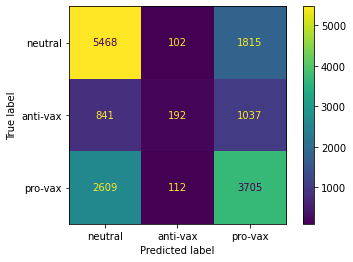

Precision-Recall-F1 - Training Data :
(0.5896983817139979, 0.5896983817139979, 0.5896983817139979, None)

Precision-Recall-F1 - Test Data :
(0.5955302366345311, 0.5955302366345311, 0.5955302366345311, None)



In [222]:
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, roc_curve, roc_auc_score
from sklearn.metrics import roc_curve, accuracy_score, mean_absolute_error

target_names = ['neutral', 'anti-vax', 'pro-vax']
df = pd.DataFrame({'true':true})
df2 = pd.DataFrame({'pred':pred})
cm = confusion_matrix(true, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot()
plt.show()

print("Precision-Recall-F1 - Training Data :")
print(precision_recall_fscore_support(true, pred, average='micro'))
print()
print("Precision-Recall-F1 - Test Data :")
print(precision_recall_fscore_support(true_dev, pred_dev, average='micro'))
print()

In [224]:
macro_roc_auc_ovo = roc_auc_score(true_dev, pred_proba, multi_class="ovo", average="macro")
weighted_roc_auc_ovo = roc_auc_score(true_dev, pred_proba, multi_class="ovo", average="weighted")
macro_roc_auc_ovr = roc_auc_score(true_dev, pred_proba, multi_class="ovr", average="macro")
weighted_roc_auc_ovr = roc_auc_score(true_dev, pred_proba, multi_class="ovr", average="weighted")
print(
    "One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
    "(weighted by prevalence)".format(macro_roc_auc_ovo, weighted_roc_auc_ovo)
)
print(
    "One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
    "(weighted by prevalence)".format(macro_roc_auc_ovr, weighted_roc_auc_ovr)
)

One-vs-One ROC AUC scores:
0.714326 (macro),
0.719999 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.727510 (macro),
0.725263 (weighted by prevalence)


In [236]:
# probabilities
df_prob = pd.DataFrame(pred_proba)
df_prob

,0,1,2
0,0.707555,0.045325,0.247120
1,0.015617,0.448182,0.536202
2,0.427904,0.147746,0.424350
3,0.697306,0.064126,0.238567
4,0.338035,0.389811,0.272154
...,...,...,...
2277,0.664956,0.070936,0.264108
2278,0.725181,0.064606,0.210213
2279,0.233897,0.257416,0.508687
2280,0.337758,0.298200,0.364042


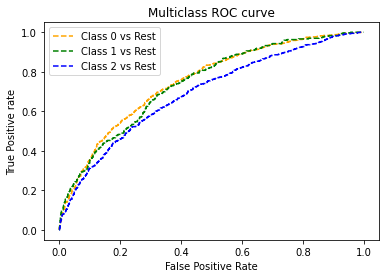

In [241]:
# roc curve for classes
fpr = {}
tpr = {}
thresh ={}

n_class = 3

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(true_dev, df_prob[i], pos_label=i)
    
# plotting    
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 1 vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class 2 vs Rest')
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC',dpi=300);  

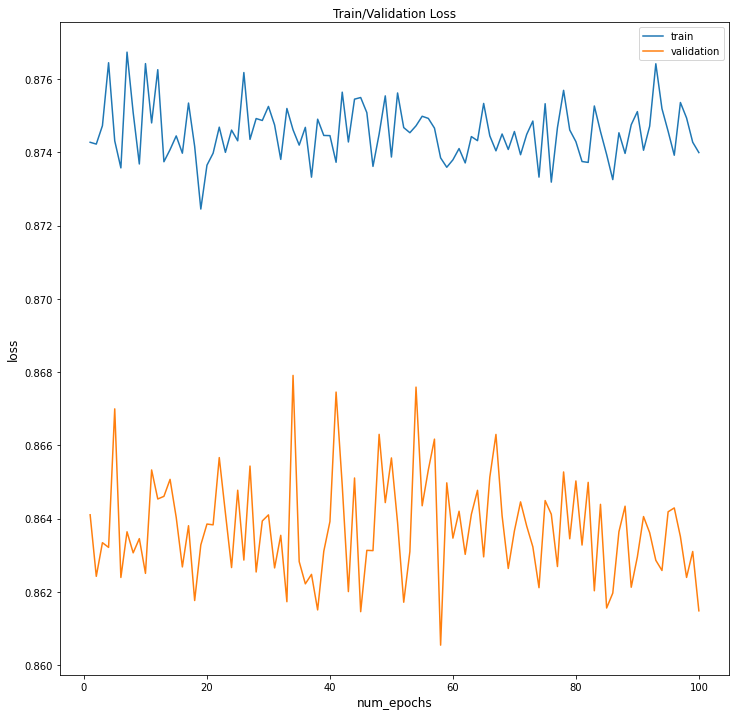

In [219]:
def plot_graph(epochs):
    fig = plt.figure(figsize=(12,12))
    plt.title("Train/Validation Loss")
    plt.plot(list(np.arange(epochs) + 1) , epoch_loss, label='train')
    plt.plot(list(np.arange(epochs) + 1), epoch_loss_dev, label='validation')
    plt.xlabel('num_epochs', fontsize=12)
    plt.ylabel('loss', fontsize=12)
    plt.legend(loc='best')
plot_graph(100)